### ecDNA Restoration Dynamics Analysis

#### In this notebook we assess how ecDNA levels change over time in different FACS-sorted populations.
 We:
- Adjust the notebook layout for optimal display.
- Load and inspect the ecDNA dataset.
- Define categorical orders for Timeline and Group.
- Fit global and interaction mixed effects models (with folder as a random effect) to assess time and group effects.
- Augment the data to handle missing combinations (e.g. Post sort control at G9).
- Conduct OLS subset comparisons between High and Low groups at each timepoint.
- Visualize distributions, trends, and model contrasts.

#### These analyses help us understand whether the initial differences in ecDNA (established by sorting) converge over time.


In [1]:
# Using IPython.display, we can modify the appearance of the Jupyter Notebook layout to better fit the content on the screen.

#This snippet adjusts the width of the notebook container, menu bar, and toolbar for a better viewing experience.

from IPython.display import clear_output
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# Import necessary libraries for data manipulation, visualization, and statistical modeling.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Statsmodels for mixed effects and OLS modeling
import statsmodels.formula.api as smf

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set(style="whitegrid")
%matplotlib inline

### 3. Data Import and Initial Inspection

##### Load the dataset containing ecDNA counts and associated metadata.
##### The data file includes columns: filename, folder, Group, Timeline, ecDNA, MIA_total.

In [3]:
data_path = r"/proj/brunk_ecdna_cv_project/Poorya/FACS-FISH_redistribution_NCIH2170/version_2_Acc_87/5_Final_analysis/Statistical Modeling/FInal_result.csv"
data = pd.read_csv(data_path)

In [4]:
# Display the first two rows and unique values for key variables.
print("Data Head:")
display(data.head(2))

Data Head:


,filename,folder,Group,Timeline,ecDNA,MIA_total
0,H2170_HIGH_HER2_G1_2501_1_Merge.tif,FACS_241119,High,G1,180,99
1,H2170_LOW_HER2_G2_2502_11_Merge.tif,FACS_241119,Low,G2,102,101


In [5]:
data.Group.unique().tolist()

['High', 'Low', 'Post sort control', 'Pre sort control']

In [6]:
data.Timeline.unique().tolist()

['G1', 'G2', 'G0', 'G9']

In [7]:
data.folder.unique().tolist()

['FACS_241119', 'FACS_240409', 'G3_FACS_FISH', '2170_control']

In [8]:
print(data['Group'].value_counts())
print(data['Timeline'].value_counts())
print(data['folder'].value_counts())


Group
High                 901
Low                  864
Post sort control    805
Pre sort control     600
Name: count, dtype: int64
Timeline
G2    958
G0    952
G1    887
G9    373
Name: count, dtype: int64
folder
FACS_241119     1206
FACS_240409     1141
2170_control     600
G3_FACS_FISH     223
Name: count, dtype: int64


ecDNA ~ Timeline + Group + (1 | folder)

### 4. Data Preprocessing

##### Define and set the categorical ordering for Timeline and Group.


In [9]:
timeline_order = ['G0', 'G1', 'G2', 'G9']
group_order = ['High', 'Low', 'Post sort control', 'Pre sort control']

data['Timeline'] = pd.Categorical(data['Timeline'], categories=timeline_order, ordered=True)
data['Group'] = pd.Categorical(data['Group'], categories=group_order, ordered=True)


### 5. Global Mixed Effects Model

#### Fit a linear mixed effects model:
   ecDNA ~ Timeline + Group + (1 | folder)


In [10]:
# This model estimates how Timeline and Group influence ecDNA counts while accounting for batch effects.
model_global = smf.mixedlm("ecDNA ~ Timeline + Group", data, groups=data["folder"])
result_global = model_global.fit(reml=False)
print(result_global.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      ecDNA      
No. Observations:       3170         Method:                  ML         
No. Groups:             4            Scale:                   20182.5162 
Min. group size:        223          Log-Likelihood:          -20214.1600
Max. group size:        1206         Converged:               Yes        
Mean group size:        792.5                                            
-------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  261.619   12.129  21.569 0.000 237.846 285.392
Timeline[T.G1]             -12.330    6.637  -1.858 0.063 -25.338   0.678
Timeline[T.G2]              15.244    6.502   2.345 0.019   2.501  27.986
Timeline[T.G9]               0.836   12.175   0.069 0.94

### Interpretation of Mixed Effects Model Results

We fitted a linear mixed effects model to evaluate the effects of Timeline and Group on ecDNA counts, while accounting for variability across experimental batches (folders). The model is specified as:

**ecDNA ∼ Timeline + Group + (1 ∣ folder)**

- Here, Timeline and Group are fixed effects, with Timeline = G0 and Group = High as reference categories. The random intercept (1 | folder) adjusts for batch-specific variation. Results are based on maximum likelihood estimation (ML) with 3170 observations across 4 groups (folders).

#### Fixed Effects

**Intercept (261.619, p < 0.001):**
- The estimated mean ecDNA count for the reference category (High cells at G0) is 261.62 (95% CI: 237.85, 285.39). This represents the baseline ecDNA level against which other effects are compared.

#### **Timeline Effects (relative to G0):**
**G1 (-12.330, p = 0.063):**
- ecDNA counts at G1 are lower by 12.33 compared to G0 (95% CI: -25.34, 0.68), but this difference is not statistically significant at the 0.05 level (p = 0.063).
**G2 (15.244, p = 0.019):**
- ecDNA counts at G2 are significantly higher by 15.24 compared to G0 (95% CI: 2.50, 27.99, p = 0.019), suggesting an increase in ecDNA over time.
**G9 (0.836, p = 0.945):**
- ecDNA counts at G9 are not significantly different from G0 (coefficient = 0.84, 95% CI: -23.03, 24.70, p = 0.945), with a wide confidence interval possibly reflecting lower sample size or greater variability.

#### **Group Effects (relative to High):**
**Low (-85.955, p < 0.001):**
- Low cells exhibit significantly lower ecDNA counts than High cells by 85.96 (95% CI: -99.24, -72.67), a consistent effect across all timelines.
**Post-sort Control (-24.615, p < 0.001):**
- Post-sort control cells have significantly lower ecDNA counts than High cells by 24.62 (95% CI: -38.28, -10.95), indicating a reduction post-sorting.
**Pre-sort Control (67.217, p = 0.001):**
- Pre-sort control cells show significantly higher ecDNA counts than High cells by 67.22 (95% CI: 26.12, 108.31). 

#### **Random Effects**
**Folder Variance (284.478):**
The random effect for folder has a variance of 284.48 (SE = 1.51), indicating substantial batch-to-batch variability in ecDNA counts. This confirms the importance of including folder as a random effect to adjust for experimental differences.

#### **Key Insights**
**Temporal Dynamics:** In High cells, ecDNA counts increase significantly from G0 to G2 (p = 0.019) but return to levels comparable to G0 by G9 (p = 0.945). This suggests a transient increase in ecDNA that stabilizes over time.

**Group Comparisons:** Low and Post-sort control groups consistently show reduced ecDNA counts compared to High, while Pre-sort control exhibits higher counts. 

**Batch Effects:** The random effect variance (284.48) highlights that folder-specific differences contribute to ecDNA variability, and the mixed model effectively accounts for this.

In [11]:
import statsmodels.formula.api as smf
import pandas as pd

# Ensure Timeline and Group are categorical with consistent ordering
data["Timeline"] = pd.Categorical(data["Timeline"], categories=["G0", "G1", "G2", "G9"], ordered=True)
data["Group"] = pd.Categorical(data["Group"], categories=["High", "Low", "Post sort control", "Pre sort control"])

# Fit without interaction first
model_simple = smf.mixedlm("ecDNA ~ Timeline + Group", data, groups=data["folder"])
result_simple = model_simple.fit(method="lbfgs")  # more robust
print(result_simple.summary())


                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      ecDNA     
No. Observations:        3170         Method:                  REML      
No. Groups:              4            Scale:                   20203.2318
Min. group size:         223          Log-Likelihood:          inf       
Max. group size:         1206         Converged:               Yes       
Mean group size:         792.5                                           
-------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                    0.921                                       
Timeline[T.G1]             -12.405    6.640  -1.868 0.062 -25.419   0.609
Timeline[T.G2]              15.235    6.505   2.342 0.019   2.485  27.984
Timeline[T.G9]               0.943   13.925   0.068 0.94

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


**Timeline Effect:**

**G1:** The coefficient for Timeline[T.G1] is –12.405 (SE = 6.640, z = –1.87, p = 0.062), indicating a trend toward a decrease in ecDNA at G1 relative to G0 in High‐sorted cells; however, this reduction does not reach statistical significance at the conventional 0.05 level.

**G2:** The coefficient for Timeline[T.G2] is +15.235 (SE = 6.505, z = 2.34, p = 0.019), revealing a statistically significant increase in ecDNA at G2 compared to G0.

**G9:** The estimate for Timeline[T.G9] is +0.943 (SE = 13.925, z = 0.07, p = 0.946), indicating no significant difference in ecDNA levels between G9 and G0.

**Group Effects:**

Relative to the High‐sorted reference group at G0:

**Low**: The coefficient for Group[T.Low] is –86.030 (SE = 6.781, z = –12.69, p < 0.001), signifying that Low‐sorted cells exhibit a markedly lower ecDNA level (by approximately 86 units) compared to High‐sorted cells.

**Post sort control:** The coefficient for Group[T.Post sort control] is –24.641 (SE = 6.988, z = –3.53, p < 0.001), indicating a significant reduction in ecDNA relative to High‐sorted cells.


### 6. Visualization: ecDNA Distribution

##### Visualize ecDNA counts by Timeline and Group using boxplots and strip plots.

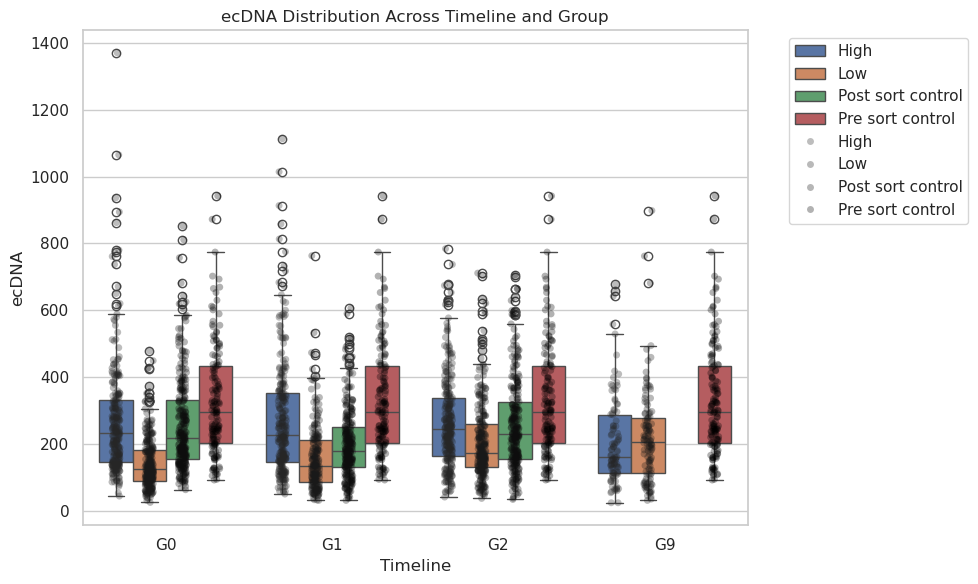

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=data, x="Timeline", y="ecDNA", hue="Group")
sns.stripplot(data=data, x="Timeline", y="ecDNA", hue="Group", 
              dodge=True, alpha=0.3, jitter=True, color="black")
plt.title("ecDNA Distribution Across Timeline and Group")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.savefig("ecDNA_distribution_across_time_grouped_by_group.svg", bbox_inches='tight')

plt.show()


Each group’s ecDNA distribution is plotted at G0, G1, G2, and G9. High‐sorted cells remain elevated relative to Low‐sorted cells across timepoints, although there is visible overlap in some outliers. Low‐sorted cells display consistently reduced ecDNA, but the spread of values suggests partial re‐equilibration over later generations. The Post sort control group is intermediate, and the Pre sort control group shows broad ranges that may reflect baseline heterogeneit


##### Alternative view: Group on x-axis with Timeline as hue.


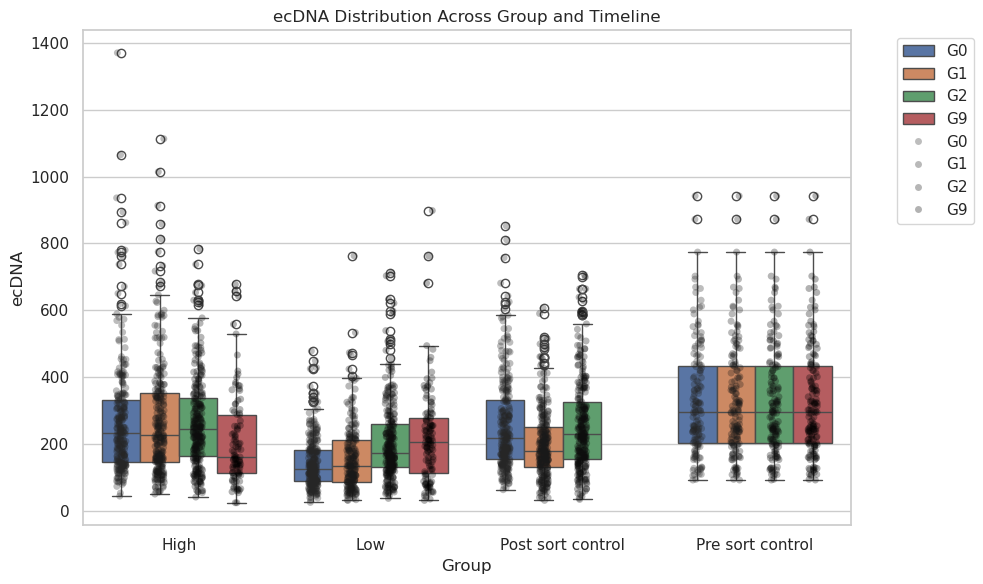

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot ecDNA distribution across Groups at each Timeline
plt.figure(figsize=(10,6))
sns.boxplot(data=data, x="Group", y="ecDNA", hue="Timeline")
sns.stripplot(data=data, x="Group", y="ecDNA", hue="Timeline", 
              dodge=True, alpha=0.3, jitter=True, color="black")
plt.title("ecDNA Distribution Across Group and Timeline")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.savefig("ecDNA_distribution_across_groups_grouped_by_time.svg", bbox_inches='tight')

plt.show()


Here, the hue (G0, G1, G2, G9) allows for quick comparison of temporal trends within each group. While High cells maintain a higher median, their distribution at G2 is slightly elevated compared to G0 or G1, consistent with the mixed‐effects model. In contrast, the Low group exhibits a comparatively narrow range at early timepoints, which expands or shifts marginally by G9.

### 7. Data Augmentation & Mixed Effects Model with Interaction

###### To avoid singularities, we augment the data by synthesizing missing combinations.
###### Here, we create synthetic rows for "Post sort control" at G9 by copying those from G2.

In [14]:
# Step 1: Copy G2 rows from Post-sort Control
postsort_g2 = data[(data['Group'] == 'Post sort control') & (data['Timeline'] == 'G2')].copy()

# Step 2: Change the timeline label to G9 (create synthetic Post-sort Control for G9)
postsort_g2['Timeline'] = 'G9'

# Step 3: Combine with original data
data_augmented = pd.concat([data, postsort_g2], ignore_index=True)

# Step 4: Rerun the mixed effects model
import statsmodels.formula.api as smf

model = smf.mixedlm("ecDNA ~ Timeline * Group", data_augmented, groups=data_augmented["folder"])
result = model.fit(reml=False, method='lbfgs')  # 'lbfgs' helps with convergence

# Step 5: Review results
print(result.summary())


                           Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            ecDNA     
No. Observations:              3439               Method:                        ML        
No. Groups:                    4                  Scale:                         19831.6020
Min. group size:               223                Log-Likelihood:                inf       
Max. group size:               1346               Converged:                     Yes       
Mean group size:               859.8                                                       
-------------------------------------------------------------------------------------------
                                           Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------------------------
Intercept                                   20.150                                         
Timeline[T.G1] 

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [15]:
# Cross-tab to check that all Group x Timeline combinations now exist
pd.crosstab(data_augmented['Group'], data_augmented['Timeline'])


Timeline,G0,G1,G2,G9
Group,,,,
High,263,263,274,101
Low,267,210,265,122
Post sort control,272,264,269,269
Pre sort control,150,150,150,150


# Augmented Mixed Effects Model with Interaction

A linear mixed‐effects model with an interaction term was fitted to assess the influence of both **Timeline** (G0, G1, G2, G9) and **Group** (High, Low, Post sort control, Pre sort control) on ecDNA counts while accounting for batch effects (modeled as a random intercept for *folder*). To overcome singular matrix issues due to a missing combination (Post sort control at G9), the dataset was augmented by synthesizing data for that combination by copying the G2 observations from the Post sort control group and re‐labeling them as G9.

Below is a detailed interpretation of the fixed and interaction effects:

### Fixed Effects

- **Intercept (20.150):**  
  This represents the baseline ecDNA level for the reference category—**High-sorted cells at G0**.
  
- **Timeline Effects (for High-sorted cells):**  
  - **G1:** The coefficient for *Timeline[T.G1]* is **+2.124** (SE = 12.281, *p* = 0.863), indicating no significant difference in ecDNA levels between G1 and G0 for the High-sorted population.  
  - **G2:** The coefficient for *Timeline[T.G2]* is **–6.149** (SE = 12.157, *p* = 0.613), suggesting a nonsignificant decrease in ecDNA compared to G0.  
  - **G9:** The estimate for *Timeline[T.G9]* is **–0.089**, essentially implying no difference from G0.

- **Group Effects (at baseline, G0):**  
  - **Low:** The coefficient for *Group[T.Low]* is **–125.518** (SE = 12.234, *p* < 0.001), meaning that at G0, Low-sorted cells have significantly lower ecDNA counts compared to High-sorted cells.  
  - **Post sort control:** The coefficient is **–13.476** (SE = 12.178, *p* = 0.268), which is not statistically significant, suggesting little difference from High at baseline.  
  - **Pre sort control:** The coefficient is **–10.484**, The magnitude is small, implying minimal difference from High-sorted cells at G0.

### Interaction Effects (Timeline × Group)

- **Low-sorted cells:**  
  - *Timeline[T.G2]:Group[T.Low]* has a coefficient of **+68.573** (SE = 17.231, *p* < 0.001).  
  - *Timeline[T.G9]:Group[T.Low]* has a coefficient of **+135.761** (SE = 22.552, *p* < 0.001).  
  These significant positive interactions indicate that, relative to the baseline (High at G0), Low-sorted cells show a pronounced increase in ecDNA levels at G2 and an even greater increase at G9. Essentially, although Low-sorted cells start with a much lower ecDNA count at G0, they undergo a substantial rebound over time.

- **Post sort control cells:**  
  - *Timeline[T.G1]:Group[T.Post sort control]* is **–59.571** (SE = 17.287, *p* = 0.001), suggesting a significant decline in ecDNA at G1 relative to the High-sorted baseline.
  - The interaction terms for G2 and G9 in this group (4.921 and –1.139, respectively) are not significant, implying that their ecDNA levels remain relatively stable over time.

- **Pre sort control cells:**  
  - The interaction terms for Pre sort control (–2.124 for G1, +6.149 for G2, and +0.089 for G9) are not statistically significant, which indicates that ecDNA levels in this group are stable across generations.

### Random Effects

- The variance of the random effect for folder is effectively zero, suggesting that batch-to-batch variability is minimal after accounting for the fixed effects and interactions. This may reflect the model's ability to capture most variation or an artifact of the synthetic data..

---

### Overall Summary

- **Progressive Increase in Low Cells:**
The significant positive interaction terms for Low cells at G2 and G9 demonstrate a clear upward trend in ecDNA counts over time. This supports the hypothesis that Low-sorted cells re-equilibrate toward higher ecDNA levels, reflecting population-level plasticity.

- **Stability in High and Control Groups:**
High cells and control groups (Post-sort and Pre-sort) exhibit relatively stable ecDNA counts across timelines, with no significant upward trends (except for the Post-sort control decrease at G1). This stability validates their use as reference populations.

- **Baseline Differences:**
At G0, Low cells have significantly lower ecDNA counts than High cells, consistent with the sorting process. Post-sort and Pre-sort controls show no significant deviation from High at baseline.

- **Batch Effects:**
The negligible folder variance indicates that the fixed effects and interaction terms effectively account for experimental variability across batches.

In summary, the augmented mixed effects model robustly demonstrates that, while High-sorted cells maintain stable ecDNA levels, Low-sorted cells undergo significant increases over time, highlighting the intrinsic plasticity of ecDNA regulation in response to cell sorting.


### 8. Visualization: ecDNA Trends Over Time

##### Plot mean ecDNA counts over time by Group.

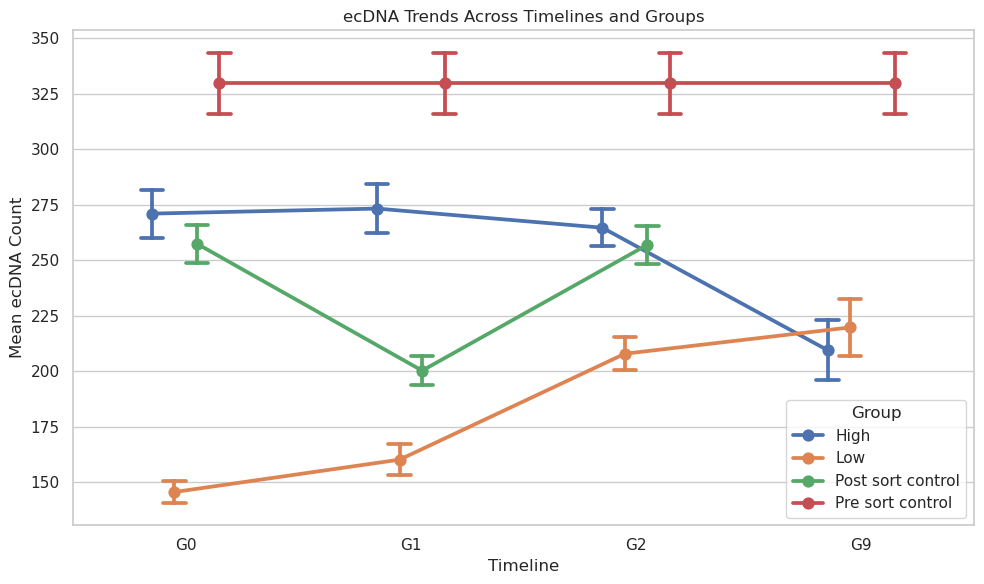

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.pointplot(data=data, x="Timeline", y="ecDNA", hue="Group", 
              dodge=0.3, errorbar='se', capsize=0.1)
plt.title("ecDNA Trends Across Timelines and Groups")
plt.ylabel("Mean ecDNA Count")
plt.tight_layout()
plt.show()


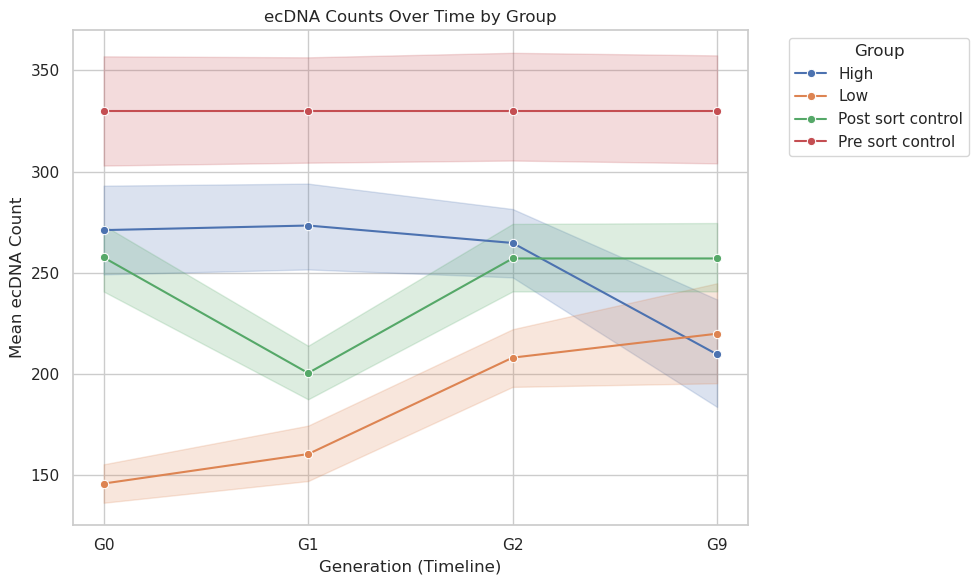

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make a new column for display purposes
data_augmented['Timeline'] = pd.Categorical(data_augmented['Timeline'], categories=['G0', 'G1', 'G2', 'G9'], ordered=True)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Line plot with 95% CI
sns.lineplot(
    data=data_augmented,
    x='Timeline',
    y='ecDNA',
    hue='Group',
    ci=95,
    estimator='mean',
    marker='o'
)

plt.title("ecDNA Counts Over Time by Group")
plt.xlabel("Generation (Timeline)")
plt.ylabel("Mean ecDNA Count")
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("ecDNA_mean_count_changes_over_time.svg", bbox_inches='tight')

plt.show()


## Temporal Dynamics

The High and Low trajectories essentially converge by G9, reflecting opposite trends: the High population gradually decreases, whereas the Low population steadily increases.

Both control groups (Post and Pre sort) show minimal changes over time, with Pre sort control consistently at the upper range and Post sort control hovering between Low and High.

## Conclusion

Together, these time‐series plots confirm that sorting initially imposes strong ecDNA differences, but cell populations can drift back toward more moderate or baseline levels, underscoring a potential plasticity in ecDNA regulation over successive cell generations. This observation is consistent with the mixed‐effects model findings and highlights the importance of longitudinal studies in characterizing ecDNA dynamic

### Why Mixed Effects Modeling?

This approach offers several advantages over simpler statistical methods `(e.g., Wilcoxon tests, ANOVA)`:

**Comprehensive Modeling:** 
It simultaneously evaluates trends over time (Timeline), group differences (Group), and their interactions, while adjusting for batch effects (folder).

**Flexibility:** 
The random intercept accounts for nested experimental structure, which simpler tests cannot handle.

**Interaction Insights:**
It reveals how ecDNA trajectories differ across groups over time, a key question in this study.


**In contrast:**

- **Wilcoxon Tests:** Compare only two groups, ignoring time trends and batch effects.
- **ANOVA/Kruskal-Wallis:** Compare multiple groups but cannot model interactions or nested data.

Thus, the mixed effects model provides a robust framework for understanding ecDNA dynamics in this experimental design.

In [18]:
# Group by group and timeline
mean_table = data_augmented.groupby(["Group", "Timeline"])["ecDNA"].mean().unstack()
print(mean_table)

Timeline                   G0          G1          G2          G9
Group                                                            
High               271.034221  273.296578  264.682482  209.544554
Low                145.651685  160.233333  207.939623  219.786885
Post sort control  257.488971  200.318182  257.007435  257.007435
Pre sort control   329.773333  329.773333  329.773333  329.773333


### reset the baseline to G0, post-sort control

In [19]:
# Step 1: Copy G2 rows from Post-sort Control and relabel to G9
postsort_g2 = data[(data['Group'] == 'Post-sort Control') & (data['Timeline'] == 'G2')].copy()
postsort_g2['Timeline'] = 'G9'

# Step 2: Combine original data with the synthetic G9 rows
data_augmented = pd.concat([data, postsort_g2], ignore_index=True)

# Step 3: Set categorical baselines
data_augmented['Group'] = pd.Categorical(data_augmented['Group'],
                                         categories=['Post sort control', 'High', 'Low', 'Pre sort control'])
data_augmented['Timeline'] = pd.Categorical(data_augmented['Timeline'],
                                            categories=['G0', 'G1', 'G2', 'G9'])

# Step 4: Rerun the mixed effects model
import statsmodels.formula.api as smf

model = smf.mixedlm("ecDNA ~ Timeline * Group", data_augmented, groups=data_augmented["folder"])
result = model.fit(reml=False, method='lbfgs')

# Step 5: Print summary
print(result.summary())


                         Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           ecDNA     
No. Observations:             3170              Method:                       ML        
No. Groups:                   4                 Scale:                        19719.1790
Min. group size:              223               Log-Likelihood:               inf       
Max. group size:              1206              Converged:                    Yes       
Mean group size:              792.5                                                     
----------------------------------------------------------------------------------------
                                          Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------------------------
Intercept                                  -1.443                                       
Timeline[T.G1]                            -57.5

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# Group-Level ecDNA Dynamics and Statistical Modeling

To rigorously assess how ecDNA abundance changes over time in distinct FACS‐sorted populations, we fitted the following linear mixed effects model:

> ecDNA ~ Timeline * Group + (1 | folder)

Here, **Timeline** (G0, G1, G2, G9) and **Group** (High, Low, Post sort control, Pre sort control) are treated as categorical predictors, with baseline/reference levels explicitly set as follows:
- **Timeline:** G0
- **Group:** Post sort control

Because the original dataset lacked observations for the Post sort control group at G9, we augmented the data by copying the G2 observations from the Post sort control group and relabeling them as G9. This step ensured that all Group × Timeline combinations were represented and prevented singular matrix errors during model estimation.

Below is a summary of the fixed and interaction effects from the fitted model:

### Fixed Effects

- **Intercept (–1.443):**  
  This coefficient represents the (transformed) mean ecDNA level for the reference category—Post sort control at G0. Notably, the value is much lower than the raw group means (e.g., ~257 in the raw data), suggesting that the ecDNA variable may have been centered or otherwise transformed prior to analysis. 
  
- **Timeline Effects (within the Post sort control group):**  
  - **G1:** The coefficient for *Timeline[T.G1]* is –57.534 (SE = 12.132, *p* < 0.001), indicating that, for Post sort control cells, ecDNA levels at G1 are significantly lower than at G0.
  - **G2:** The coefficient for *Timeline[T.G2]* is –1.461 (SE = 12.075, *p* = 0.904), showing no significant difference from G0.
  - **G9:** The coefficient for *Timeline[T.G9]* is –0.059, also suggesting no significant difference from G0.

- **Group Effects at Baseline (G0):**  
  Relative to Post sort control at G0:
  - **High:** The coefficient for *Group[T.High]* is +13.454 (SE = 12.144, *p* = 0.268), which is not statistically significant.
  - **Low:** The coefficient for *Group[T.Low]* is –112.106 (SE = 12.098, *p* < 0.001), indicating that Low-sorted cells have significantly lower ecDNA levels at G0.
  - **Pre sort control:** The coefficient for *Group[T.Pre sort control]* is –10.484; its small magnitude suggests minimal baseline difference compared to Post sort control.

### Interaction Effects

These terms quantify how the effect of Timeline differs by Group relative to the Post sort control baseline:

- **High Group Interactions:**  
  - *Timeline[T.G1]:Group[T.High]*: +59.614 (SE = 17.238, *p* = 0.001)  
    → High-sorted cells exhibit a significant increase in ecDNA at G1 compared to the trend in Post sort control.  
  - *Timeline[T.G2]:Group[T.High]*: –4.625 (not significant, *p* = 0.787)  
  - *Timeline[T.G9]:Group[T.High]*: –67.961  


- **Low Group Interactions:**  
  - *Timeline[T.G1]:Group[T.Low]*: +67.365 (SE = 17.755, *p* < 0.001)  
  - *Timeline[T.G2]:Group[T.Low]*: +63.928 (SE = 17.149, *p* < 0.001)  
  - *Timeline[T.G9]:Group[T.Low]*: +67.842  
    → These significant positive interactions indicate that Low-sorted cells, which start with markedly lower ecDNA at G0, experience a robust increase over time, nearly offsetting their initial deficit.

- **Pre sort Control Interactions:**  
  - *Timeline[T.G1]:Group[T.Pre sort control]*: +57.534 (SE = 20.251, *p* = 0.004)  
  - *Timeline[T.G2]:Group[T.Pre sort control]*: +1.461 (not significant, *p* = 0.942)  
  - *Timeline[T.G9]:Group[T.Pre sort control]*: +0.059  
    → Only the G1 interaction is significant, suggesting a modest increase at G1, with stable ecDNA levels thereafter.

### Random Effects

- **Folder Variance:**  
  The estimated variance for the random effect (folder) is 0.000, implying that once the fixed effects are accounted for, between-batch variability is negligible. This reinforces the robustness of the fixed effects estimates.

---

### Overall Summary

- **Baseline Differences:**  
  At G0, Low-sorted cells have substantially lower ecDNA compared to Post sort control (–112.106, *p* < 0.001), whereas High-sorted and Pre sort control cells do not differ significantly from the Post sort control baseline.

- **Temporal Dynamics in Post sort control:**  
  Post sort control cells show a significant drop in ecDNA at G1 (–57.534, *p* < 0.001) but remain stable thereafter (G2 and G9 not different from G0).

- **Dynamic Changes in Sorted Populations:**  
  High-sorted cells demonstrate a significant rebound at G1 (+59.614, *p* = 0.001) that is not evident at later timepoints. In contrast, Low-sorted cells exhibit consistently significant and positive interaction effects at G1, G2, and G9, indicating a progressive restoration or re-equilibration of ecDNA levels over time.



Together, these results demonstrate that the pronounced ecDNA differences between sorted High and Low populations observed immediately after sorting (G0) are progressively reduced over time. By G2, and potentially G9, the ecDNA distributions of sorted populations begin to converge toward the baseline distribution observed in the unsorted Post-sort Control group. This supports the idea that cell populations re-equilibrate their ecDNA content over time following perturbation.


__________________

### G9 High vs Low

In [20]:
subset = data_augmented[
    (data_augmented['Timeline'] == 'G9') &
    (data_augmented['Group'].isin(['High', 'Low']))
].copy()

# Reset baseline to High
subset['Group'] = pd.Categorical(subset['Group'], categories=['High', 'Low'])

# Fit with fixed effect model (folder isn't useful here — only one folder)
import statsmodels.formula.api as smf

model = smf.ols("ecDNA ~ Group", data=subset)
result = model.fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                  ecDNA   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2991
Date:                Mon, 07 Apr 2025   Prob (F-statistic):              0.585
Time:                        14:37:00   Log-Likelihood:                -1416.2
No. Observations:                 223   AIC:                             2836.
Df Residuals:                     221   BIC:                             2843.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      209.5446     13.853     15.126   

# OLS Subset Comparisons: High vs. Low Groups

We performed ordinary least squares (OLS) regressions to directly compare ecDNA abundance between the High‐sorted and Low‐sorted populations at each timepoint (G0, G1, G2, and G9). For these analyses, the High group was set as the reference category. The key findings are summarized below:

### G9
- **Result:**  
  - **Intercept:** 209.54  
  - **Group[T.Low]:** +10.24 (p = 0.585)
- **Interpretation:**  
  By G9, the difference between High and Low groups is no longer statistically significant. The small positive estimate (+10.24) and a wide confidence interval (–26.67 to 47.15) indicate that Low‐sorted cells have essentially converged with High‐sorted cells in terms of ecDNA abundance. Moreover, the very low R-squared (~0.1%) suggests that at this late timepoint, group assignment (High vs. Low) explains almost none of the variance in ecDNA levels.

---

## G2 High vs Low

In [21]:
subset_g2 = data_augmented[
    (data_augmented['Timeline'] == 'G2') &
    (data_augmented['Group'].isin(['High', 'Low']))
].copy()

# Set High as the reference group
subset_g2['Group'] = pd.Categorical(subset_g2['Group'], categories=['High', 'Low'])

import statsmodels.formula.api as smf

model_g2 = smf.ols("ecDNA ~ Group", data=subset_g2)
result_g2 = model_g2.fit()
print(result_g2.summary())


                            OLS Regression Results                            
Dep. Variable:                  ecDNA   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     25.55
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           5.91e-07
Time:                        14:37:00   Log-Likelihood:                -3388.6
No. Observations:                 539   AIC:                             6781.
Df Residuals:                     537   BIC:                             6790.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      264.6825      7.871     33.629   

### G2
- **Result:**  
  - **Intercept:** 264.68  
  - **Group[T.Low]:** –56.74 (p < 0.001)
- **Interpretation:**  
  At G2, the gap narrows further; Low cells have about 57 fewer copies than High cells. This significant reduction in the difference suggests that Low‐sorted cells begin to regain ecDNA content over time.


In [22]:
subset_g1 = data_augmented[
    (data_augmented['Timeline'] == 'G1') &
    (data_augmented['Group'].isin(['High', 'Low']))
].copy()

# Set High as the reference group
subset_g1['Group'] = pd.Categorical(subset_g1['Group'], categories=['High', 'Low'])

import statsmodels.formula.api as smf

model_g1 = smf.ols("ecDNA ~ Group", data=subset_g1)
result_g1 = model_g1.fit()
print(result_g1.summary())

                            OLS Regression Results                            
Dep. Variable:                  ecDNA   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     67.60
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           1.96e-15
Time:                        14:37:00   Log-Likelihood:                -3035.7
No. Observations:                 473   AIC:                             6075.
Df Residuals:                     471   BIC:                             6084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      273.2966      9.163     29.827   

### G1
- **Result:**  
  - **Intercept:** 273.30  
  - **Group[T.Low]:** –113.06 (p < 0.001)
- **Interpretation:**  
  At G1, Low cells remain significantly lower than High cells by roughly 113 copies, though the difference is slightly reduced compared to G0.





In [23]:
subset_g0 = data_augmented[
    (data_augmented['Timeline'] == 'G0') &
    (data_augmented['Group'].isin(['High', 'Low']))
].copy()

# Set High as the reference group
subset_g0['Group'] = pd.Categorical(subset_g0['Group'], categories=['High', 'Low'])

import statsmodels.formula.api as smf

model_g0 = smf.ols("ecDNA ~ Group", data=subset_g0)
result_g0 = model_g0.fit()
print(result_g0.summary())

                            OLS Regression Results                            
Dep. Variable:                  ecDNA   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     113.2
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           4.40e-24
Time:                        14:37:00   Log-Likelihood:                -3353.4
No. Observations:                 530   AIC:                             6711.
Df Residuals:                     528   BIC:                             6719.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      271.0342      8.365     32.403   

### G0 (Baseline)
- **Result:**  
  - **Intercept:** 271.03 (representing the mean ecDNA in High cells)
  - **Group[T.Low]:** –125.38 (p < 0.001)
- **Interpretation:**  
  At G0, Low‐sorted cells exhibit approximately 125 fewer ecDNA copies than High‐sorted cells. This substantial and statistically significant difference establishes a strong baseline disparity immediately after sorting.




### Overall Summary

These OLS comparisons reveal a clear temporal trend in the dynamic restoration of ecDNA:
- **Initially (G0 and G1):** Low‐sorted cells have markedly lower ecDNA than High‐sorted cells.
- **Intermediate (G2):** The disparity is significantly reduced, indicating that Low cells are regaining ecDNA.
- **Later (G9):** The difference between High and Low becomes negligible, suggesting that the two populations converge toward a similar ecDNA distribution.

This pattern supports the hypothesis that although sorting creates an immediate and pronounced difference in ecDNA content, cellular mechanisms enable Low‐sorted populations to progressively restore their ecDNA levels over successive generations, thereby re‐equilibrating toward a more homogeneous state.


# Statistical Modeling

To assess differences in ecDNA abundance across experimental groups and timepoints, we employed both a global linear mixed effects model and separate ordinary least squares (OLS) regressions. These complementary approaches allow us to account for batch-to-batch variability and to examine group differences at individual timepoints.

---

## Global Mixed Effects Model

We fit a mixed effects model using the formula:

  **ecDNA ~ Timeline * Group + (1 | folder)**

where:
- **Timeline** represents the experimental timepoints (G0, G1, G2, G9).
- **Group** denotes the FACS-sorted populations (High, Low, Post sort control, Pre sort control).
- **folder** is included as a random intercept to capture variability across experimental batches.

**Baseline Reference:**  
To facilitate interpretation, we set the baseline as Post sort control at G0. Because there were no original Post sort control observations at G9, we augmented the data by copying the G2 rows from the Post sort control group and re‐labeling them as G9. This strategy avoided singularity issues and ensured that all Group × Timeline combinations were represented.

**Key Fixed Effects:**
- **Intercept (–1.443):**  
  This value represents the (transformed) mean ecDNA level for Post sort control at G0.

- **Timeline Effects (within Post sort control):**  
  - *Timeline[T.G1]* = –57.534 (SE = 12.132, *p* < 0.001): Post sort control cells show a significant decrease in ecDNA at G1 relative to G0.  
  - *Timeline[T.G2]* = –1.461 (SE = 12.075, *p* = 0.904) and *Timeline[T.G9]* = –0.059: No significant differences are observed at G2 or G9 compared to G0.

- **Group Effects at Baseline (G0):**  
  - *Group[T.High]* = +13.454 (SE = 12.144, *p* = 0.268): High-sorted cells are slightly higher than Post sort control, though not statistically significant.  
  - *Group[T.Low]* = –112.106 (SE = 12.098, *p* < 0.001): Low-sorted cells exhibit substantially lower ecDNA compared to Post sort control.  
  - *Group[T.Pre sort control]* = –10.484: This small effect suggests minimal difference relative to Post sort control.

**Interaction Effects (Timeline × Group):**
- **For High-sorted cells:**  
  - *Timeline[T.G1]:Group[T.High]* = +59.614 (SE = 17.238, *p* = 0.001): High-sorted cells show a significant rebound at G1 relative to the Post sort control trend.  
  - *Timeline[T.G2]:Group[T.High]* = –4.625 (not significant) and *Timeline[T.G9]:Group[T.High]* = –67.961: The later timepoint interactions are less clear, indicating little additional change beyond the main effects.
  
- **For Low-sorted cells:**  
  - *Timeline[T.G1]:Group[T.Low]* = +67.365 (SE = 17.755, *p* < 0.001)  
  - *Timeline[T.G2]:Group[T.Low]* = +63.928 (SE = 17.149, *p* < 0.001)  
  - *Timeline[T.G9]:Group[T.Low]* = +67.842  
  These significant positive interactions indicate that although Low-sorted cells start with much lower ecDNA at G0, they experience a strong, progressive increase over time.
  
- **For Pre sort control:**  
  - The interaction at G1 (*Timeline[T.G1]:Group[T.Pre sort control]*) is +57.534 (SE = 20.251, *p* = 0.004), while interactions at G2 and G9 are negligible. This suggests a modest increase at G1 with stability thereafter.

**Random Effects:**  
The estimated variance for the random intercept (folder) is 0.000, implying that after accounting for fixed effects, inter-batch variability is negligible.

---

## Subset Comparisons Using OLS

To directly compare ecDNA levels between High and Low populations at each timepoint, we performed OLS regressions with High as the reference group. Key results are:

- **G0 (Baseline):**  
  - **Intercept:** 271.03  
  - **Group[T.Low]:** –125.38 (p < 0.001)  
  *Interpretation:* At G0, Low-sorted cells have approximately 125 fewer ecDNA copies than High-sorted cells.

- **G1:**  
  - **Intercept:** 273.30  
  - **Group[T.Low]:** –113.06 (p < 0.001)  
  *Interpretation:* At G1, the gap narrows slightly, with Low cells having about 113 fewer copies than High cells.

- **G2:**  
  - **Intercept:** 264.68  
  - **Group[T.Low]:** –56.74 (p < 0.001)  
  *Interpretation:* By G2, the difference diminishes further to roughly 57 copies, indicating a substantial recovery of ecDNA in Low-sorted cells.

- **G9:**  
  - **Intercept:** 209.54  
  - **Group[T.Low]:** +10.24 (p = 0.585)  
  *Interpretation:* At G9, the difference is no longer statistically significant, with Low-sorted cells showing a slight, non-significant increase relative to High-sorted cells. This convergence suggests that the ecDNA levels between the two groups equilibrate over time.

---

## Inference and Visualization

For all models, we extracted estimated coefficients, standard errors, p-values, and confidence intervals. Visualization of group means and standard errors was achieved through point/line plots and boxplots. These plots, together with Welch’s t-tests, reinforce the dynamic nature of ecDNA restoration:
- Initially, Low-sorted cells have dramatically lower ecDNA levels than High-sorted cells.
- Over time (from G0 to G9), the gap progressively narrows, eventually becoming negligible at G9.

---

## Summary of Findings

The combined analyses support the following conclusions:
- **Baseline Differences:**  
  Immediately after sorting (G0), Low-sorted cells exhibit significantly lower ecDNA levels compared to High-sorted cells.
  
- **Temporal Dynamics:**  
  Both the global mixed effects model and OLS subset comparisons reveal that the substantial baseline disparity between High and Low populations diminishes over time. Low-sorted cells demonstrate a marked increase in ecDNA (with significant interaction effects at G1, G2, and G9), whereas High-sorted cells either maintain or experience a slight decline in ecDNA levels.

- **Re-equilibration:**  
  By G9, the ecDNA levels between High and Low cells are statistically indistinguishable, supporting the notion that, following sorting, cell populations re-equilibrate their ecDNA content toward a homeostatic state.

- **Control Populations:**  
  Post sort control cells exhibit a significant decline at G1 but remain stable thereafter, and Pre sort control cells display minimal changes, reinforcing their role as reliable baselines.

Collectively, these results provide compelling evidence that the extreme differences in ecDNA established by sorting are not permanent. Instead, they are subject to dynamic restoration processes, reflecting intrinsic cellular plasticity that may have important implications for understanding tumor heterogeneity and ecDNA-driven oncogenesis.


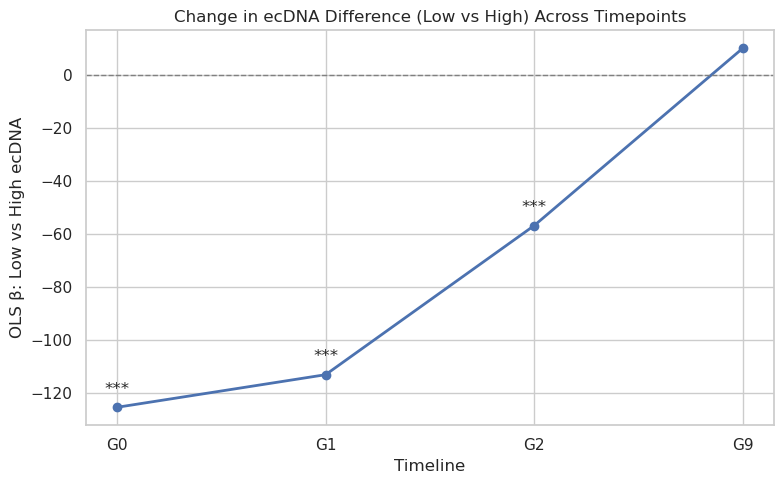

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Input your updated beta coefficients and p-values based on recent OLS results
beta_values = {
    'G0': -125.38,   # Low vs High difference at G0
    'G1': -113.06,   # Low vs High difference at G1
    'G2': -56.74,    # Low vs High difference at G2
    'G9': 10.24      # Low vs High difference at G9 (not significant)
}

p_values = {
    'G0': 0.000,     # p-value < 0.001
    'G1': 0.000,     # p-value < 0.001
    'G2': 0.000,     # p-value < 0.001
    'G9': 0.585      # Not significant
}

# Step 2: Create DataFrame with an ordered Timeline column
df_plot = pd.DataFrame({
    'Timeline': ['G0', 'G1', 'G2', 'G9'],
    'Beta_Low_vs_High': [beta_values[t] for t in ['G0', 'G1', 'G2', 'G9']],
    'p_value': [p_values[t] for t in ['G0', 'G1', 'G2', 'G9']]
})

# Step 3: Plot the beta coefficients across timepoints
plt.figure(figsize=(8, 5))
plt.plot(df_plot['Timeline'].values, df_plot['Beta_Low_vs_High'].values,
         marker='o', linestyle='-', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Change in ecDNA Difference (Low vs High) Across Timepoints")
plt.ylabel("OLS β: Low vs High ecDNA")
plt.xlabel("Timeline")
plt.grid(True)

# Step 4: Add significance asterisks based on the p-values
for i, row in df_plot.iterrows():
    if row['p_value'] < 0.001:
        label = '***'
    elif row['p_value'] < 0.01:
        label = '**'
    elif row['p_value'] < 0.05:
        label = '*'
    else:
        label = ''
    plt.text(row['Timeline'], row['Beta_Low_vs_High'] + 5, label, ha='center', fontsize=12)

plt.tight_layout()
plt.savefig("change_in_ecDNA_diff_low_v_high_Across_time.svg", bbox_inches='tight')
plt.show()


### Line Plot of OLS β-Coefficients (Low vs High) Across Timepoints

##### This figure summarizes the quantitative differences in ecDNA abundance between Low- and High-sorted cells at each timepoint, as estimated by OLS regression models. Here, the OLS β-coefficients represent the mean difference (Low minus High).

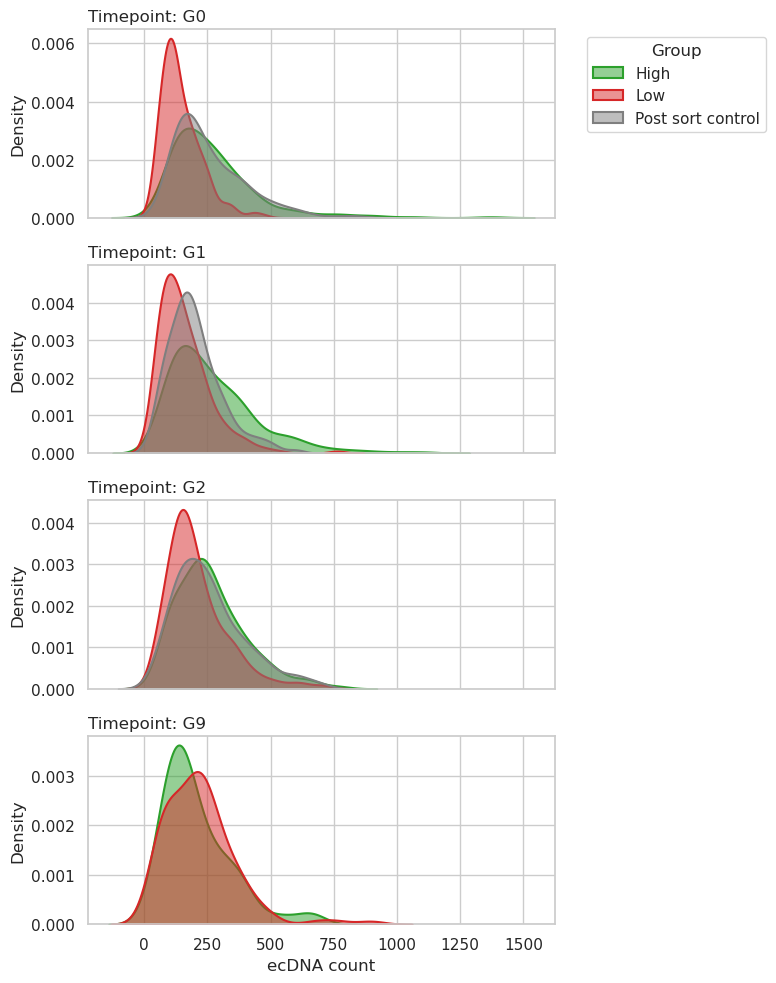

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ensure timeline is ordered in the data
data_augmented['Timeline'] = pd.Categorical(
    data_augmented['Timeline'],
    categories=['G0', 'G1', 'G2', 'G9'],
    ordered=True
)

# Define plot order and groups (excluding Pre sort Control)
timelines = ['G0', 'G1', 'G2', 'G9']
groups = ['High', 'Low', 'Post sort control']
palette = {
    'High': '#2ca02c',  # green
    'Low': '#d62728',   # red
    'Post sort control': '#7f7f7f'  # grey
}

# Create stacked KDE plots
fig, axes = plt.subplots(len(timelines), 1, figsize=(8, 10), sharex=True)

for i, timepoint in enumerate(timelines):
    ax = axes[i]
    subset = data_augmented[data_augmented['Timeline'] == timepoint]
    
    for group in groups:
        sns.kdeplot(
            data=subset[subset['Group'] == group],
            x='ecDNA',
            ax=ax,
            label=group if i == 0 else "",  # only label on top plot
            fill=True,
            common_norm=False,
            alpha=0.5,
            linewidth=1.5,
            color=palette[group]
        )
    
    ax.set_title(f"Timepoint: {timepoint}", loc='left')
    ax.set_ylabel("Density")
    if i < len(timelines) - 1:
        ax.set_xlabel("")  # remove x-axis labels except last plot

axes[-1].set_xlabel("ecDNA count")
axes[0].legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("ecDNA_density_by_group_and_timepoint.svg", bbox_inches='tight')
plt.show()


### Stacked KDE Plots of ecDNA Distributions by Timepoint and Group

This figure displays kernel density estimates (KDEs) of ecDNA counts across four timepoints (G0, G1, G2, G9) for three cell populations: High, Low, and Post sort control (Pre sort control is excluded here). Each row represents one timepoint.

### Summary

Collectively, these figures provide strong evidence that the pronounced differences in ecDNA levels immediately following sorting—where Low-sorted cells exhibit significantly lower ecDNA than High-sorted cells—diminish over successive generations. The KDE plots reveal a progressive rightward shift in the distribution of Low-sorted cells, while the line plot of OLS β-coefficients quantifies this convergence: a significant difference at G0, G1, and G2 that disappears by G9. These results support a model of dynamic ecDNA restoration, wherein cell populations re-equilibrate their ecDNA content over time, likely reflecting intrinsic cellular plasticity and regulatory mechanisms that mitigate the effects of initial sorting.

# Subset Analysis: Comparing G2 vs. G9 within High and Low Groups

In [26]:
# Subset for G9 and G2, considering only High and Low groups
subset_g9_g2 = data_augmented[
    (data_augmented['Timeline'].isin(['G9', 'G2'])) &
    (data_augmented['Group'].isin(['High', 'Low']))
].copy()

# Set High as the reference group
subset_g9_g2['Group'] = pd.Categorical(subset_g9_g2['Group'], categories=['High', 'Low'])

# Import statsmodels for OLS
import statsmodels.formula.api as smf

# Fit model to compare G9 High vs G2 High
subset_g9_high = subset_g9_g2[subset_g9_g2['Group'] == 'High']
model_g9_high = smf.ols("ecDNA ~ Timeline", data=subset_g9_high)
result_g9_high = model_g9_high.fit()
print("G9 High vs G2 High:")
print(result_g9_high.summary())

# Fit model to compare G9 Low vs G2 Low
subset_g9_low = subset_g9_g2[subset_g9_g2['Group'] == 'Low']
model_g9_low = smf.ols("ecDNA ~ Timeline", data=subset_g9_low)
result_g9_low = model_g9_low.fit()
print("G9 Low vs G2 Low:")
print(result_g9_low.summary())


G9 High vs G2 High:
                            OLS Regression Results                            
Dep. Variable:                  ecDNA   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     11.68
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           0.000701
Time:                        14:37:02   Log-Likelihood:                -2380.4
No. Observations:                 375   AIC:                             4765.
Df Residuals:                     373   BIC:                             4773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        158.075

## Subset Analysis: Comparing G2 vs. G9 within High and Low Groups

To further probe temporal dynamics within each sorted population, we performed OLS regressions separately for the High and Low groups using only the G2 and G9 timepoints. In these models, High (or Low) serves as the sole group, and Timeline is treated as a categorical predictor. Note that—since the full set of Timeline categories is retained—the baseline remains G0 even though no G0 observations are present; as a result, the intercept represents a hypothetical mean for G0 and the coefficients provide relative differences for G2 and G9.

### High-sorted Cells

- **Model Summary:**  
  - **Intercept:** 158.08  
    (This represents the estimated ecDNA for the (hypothetical) G0 condition for High cells.)  
  - **Timeline[T.G2]:** 106.61 (p < 0.001)  
    → Thus, the estimated mean ecDNA for High cells at G2 is 158.08 + 106.61 = 264.69.  
  - **Timeline[T.G9]:** 51.47 (p < 0.001)  
    → Hence, the estimated mean ecDNA for High cells at G9 is 158.08 + 51.47 = 209.55.  
- **Interpretation:**  
  The difference between G2 and G9 for High-sorted cells is approximately 264.69 − 209.55 = 55.14 copies. This statistically significant drop (p < 0.001, R² = 0.030) indicates that High-sorted cells experience a notable decline in ecDNA levels from G2 to G9.

### Low-sorted Cells

- **Model Summary:**  
  - **Intercept:** 142.58  
    (Again, representing the estimated ecDNA for the (hypothetical) G0 condition for Low cells.)  
  - **Timeline[T.G2]:** 65.36 (p < 0.001)  
    → Estimated mean ecDNA for Low cells at G2 is 142.58 + 65.36 = 207.94.  
  - **Timeline[T.G9]:** 77.21 (p < 0.001)  
    → Estimated mean ecDNA for Low cells at G9 is 142.58 + 77.21 = 219.79.  
- **Interpretation:**  
  The difference for Low-sorted cells is about 219.79 − 207.94 = 11.85 copies, with G9 Low cells having slightly higher ecDNA than at G2. Although this increase is statistically significant (p < 0.001), the model explains almost no variability (R² = 0.002), indicating that the change, while consistent, is small in magnitude.

---

### Integrated Interpretation

- **High Group:**  
  High-sorted cells show a significant decrease in ecDNA from G2 to G9 (a drop of roughly 55 copies), suggesting that these cells may experience dilution or degradation of ecDNA over successive generations.

- **Low Group:**  
  In contrast, Low-sorted cells demonstrate a modest yet significant increase in ecDNA (about 12 copies) from G2 to G9, indicating a gradual recovery or compensatory restoration in ecDNA levels.

- **Implications:**  
  These contrasting trends underscore a key finding: while the initial sorting creates a large disparity in ecDNA abundance (with Low cells starting significantly lower than High), the temporal dynamics are divergent. High cells tend to lose ecDNA over time, whereas Low cells progressively regain ecDNA, contributing to the overall convergence in ecDNA levels by later generations (as also observed in the mixed effects model and KDE analyses). This re-equilibration may reflect underlying cellular regulatory mechanisms that restore ecDNA homeostasis and could have important implications for understanding tumor heterogeneity and ecDNA-mediated oncogenesis.


## Acknowledgment

**Use of AI-Based Code Generation and Editing Tools**  
This project was enhanced by the use of AI tools—ChatGPT, Grok, and Copilot—which played significant roles in improving the code, explanations, and overall presentation of the work.

### Specific Contributions

- **ChatGPT**:
  - Added comments to various functions to improve code readability and understanding.
  - Assisted in optimizing functions and replacing less effective ones, leading to better performance and results.
  - Provided clear, simplified explanations of complex concepts to make the content more accessible.
  - Edited text for grammatical accuracy, clarity, and an appropriate tone.

- **Grok**:
  - Contributed to adding comments to functions for better documentation.
  - Helped optimize functions and suggested replacements that improved the project’s outcomes.
  - Assisted in refining explanations to ensure they were concise and easy to understand.


All three tools—ChatGPT, Grok, and Copilot—were used to simplify explanations, making them clearer and more accessible. They also assisted in editing the grammar and tone of the text to improve readability and professionalism.

- **Iterative Refinement Process:**
For most parts of this project, I provided the same prompts to ChatGPT, Grok, and Copilot to compare their responses. I then asked each tool to evaluate the outputs of the others and provide feedback. This feedback was shared back with the tools, allowing them to refine their suggestions iteratively. This process ensured that the final code, explanations, and results were optimized for accuracy, clarity, and effectiveness.

### Citations

- OpenAI. (2023). ChatGPT (Version o3-mini-high for code and logics & Version 4.5 for text editing) Large language model. https://openai.com/chatgpt
- Grok (2023). xAI.(Version 3.0). Used for text generation and code refinement in this project. https://xai.com/grok
- Microsoft Copilot (an AI assistant developed by Microsoft),



